# Dataframe manipulation for dataset assembly

In [27]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pybedtools
from pyfaidx import Fasta
from Bio import SeqIO
from Bio.SeqUtils import GC
mpl.rcParams['figure.dpi']= 100

In [28]:
# Importing all the necessary data
mm_fasta = pybedtools.BedTool('data/GRCm38.p6.genome.fa')
iap_bed = pybedtools.BedTool('data/clean.mm10.IAP.mended.extent.bed')
vm_bed = pybedtools.BedTool('data/clean.IAP_validation.July2019.stranded.bed')
genes_bed = pybedtools.BedTool('data/clean.genes.bed')

In [41]:
# Looking at vm_iap dataset, getting element ids of validated IAPs
column_names = ["chrom1", "start1", "end1", "strand1", "name", "un1",
                "un2", "val_result", "chrom2", "start3", "end3", 
                "element_id", "length1", "strand2", "length2"]
vm_df = vm_bed.intersect(iap_bed, wo=True).to_dataframe(names = column_names)

# Cleaning dataframe
vm_df = vm_df.drop(columns=["chrom1", "start1", "end1", "strand1", "name", "un1",
                            "un2", "chrom2", "start3", "end3", 
                            "length1", "strand2", "length2"])
vm_df.loc[:, "element_id"] = vm_df.loc[:, "element_id"].apply(pd.to_numeric)
vm_df.index = vm_df["element_id"].astype(int).to_list()
vm_df = vm_df.drop(columns="element_id")
vm_df['index'] = vm_df.index
vm_df = vm_df.sort_index()

# Displaying dataframe
print(vm_df.shape)
vm_df

(104, 2)


,val_result,index
7451,True ME,7451
30577,False-positive,30577
138576,False-positive,138576
161486,False-positive,161486
174086,False-positive,174086
...,...,...
4389356,True ME,4389356
4483390,Tissue-specific,4483390
4486375,Tissue-specific,4486375
4488835,True ME,4488835


In [42]:
# Generating the relevant dataframe, for eventual use in stat learning
iap_df = iap_bed.to_dataframe()
iap_df = iap_df.rename(columns={"name": "element_id", "score": "length"})
iap_df.index = iap_df["element_id"].to_list()
iap_df = iap_df.drop(columns="element_id")
iap_df = iap_df.sort_index()
iap_df['index'] = iap_df.index
iap_df

,chrom,start,end,length,strand,index
28,chr1,3031358,3031710,353,-,28
182,chr1,3143092,3148151,5060,-,182
1272,chr1,3997836,3998160,325,-,1272
1427,chr1,4132179,4132516,338,-,1427
1976,chr1,4556987,4559597,2611,-,1976
...,...,...,...,...,...,...
4644718,chrY,90569911,90574359,4449,-,4644718
4644724,chrY,90583921,90584222,302,+,4644724
4644849,chrY,90667602,90667783,182,-,4644849
4644891,chrY,90702165,90703909,1745,+,4644891


In [47]:
# Extracting nucleotide content from IAPs
nuc_content = iap_bed.nucleotide_content(fi=mm_fasta, s=True)

# Generating clean dataframe
df_names = ["chrom", "start", "end", "element_id",
            "length", "strand", "pct_at", "pct_gc",
            "num_A", "num_C", "num_G", "num_T", "num_N",
            "num_other", "seq_len"]
nuc_df = nuc_content.to_dataframe(names=df_names)
nuc_df = nuc_df.drop(index=0)
nuc_df.index = nuc_df["element_id"].astype(int).to_list()
nuc_df = nuc_df.drop(columns=["element_id",  "num_N", "num_other", "seq_len"])
nuc_df.loc[:, "pct_at":"num_T"] = nuc_df.loc[:, "pct_at":"num_T"].apply(pd.to_numeric)
nuc_df.loc[:, "start":"length"] = nuc_df.loc[:, "start":"length"].apply(pd.to_numeric)
nuc_df = nuc_df.sort_index()
nuc_df['index'] = nuc_df.index
nuc_df

,chrom,start,end,length,strand,pct_at,pct_gc,num_A,num_C,num_G,num_T,index
28,chr1,3031358,3031710,353,-,0.480114,0.519886,68,91,92,101,28
182,chr1,3143092,3148151,5060,-,0.581538,0.418462,1493,969,1148,1449,182
1272,chr1,3997836,3998160,325,-,0.484568,0.515432,72,85,82,85,1272
1427,chr1,4132179,4132516,338,-,0.480712,0.519288,68,85,90,94,1427
1976,chr1,4556987,4559597,2611,-,0.549425,0.450575,699,543,633,735,1976
...,...,...,...,...,...,...,...,...,...,...,...,...
4644718,chrY,90569911,90574359,4449,-,0.551484,0.448516,1328,908,1087,1125,4644718
4644724,chrY,90583921,90584222,302,+,0.528239,0.471761,79,64,78,80,4644724
4644849,chrY,90667602,90667783,182,-,0.458564,0.541436,39,54,44,44,4644849
4644891,chrY,90702165,90703909,1745,+,0.579128,0.420872,495,375,359,515,4644891


In [48]:
# Combining total IAP and VM-IAP dataframes

def check_intersection(x):
    if x["index"] in vm_df["index"]:
        x["val_result"] = vm_df.loc[x["index"], "val_result"]
        return x
    else:
        x["val_result"] = "untested"
        return x

nuc_df = nuc_df.apply(check_intersection, axis=1)
nuc_df

,chrom,start,end,length,strand,pct_at,pct_gc,num_A,num_C,num_G,num_T,index,val_result
28,chr1,3031358,3031710,353,-,0.480114,0.519886,68.0,91.0,92.0,101.0,28,untested
182,chr1,3143092,3148151,5060,-,0.581538,0.418462,1493.0,969.0,1148.0,1449.0,182,untested
1272,chr1,3997836,3998160,325,-,0.484568,0.515432,72.0,85.0,82.0,85.0,1272,untested
1427,chr1,4132179,4132516,338,-,0.480712,0.519288,68.0,85.0,90.0,94.0,1427,untested
1976,chr1,4556987,4559597,2611,-,0.549425,0.450575,699.0,543.0,633.0,735.0,1976,untested
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4644718,chrY,90569911,90574359,4449,-,0.551484,0.448516,1328.0,908.0,1087.0,1125.0,4644718,untested
4644724,chrY,90583921,90584222,302,+,0.528239,0.471761,79.0,64.0,78.0,80.0,4644724,untested
4644849,chrY,90667602,90667783,182,-,0.458564,0.541436,39.0,54.0,44.0,44.0,4644849,untested
4644891,chrY,90702165,90703909,1745,+,0.579128,0.420872,495.0,375.0,359.0,515.0,4644891,untested


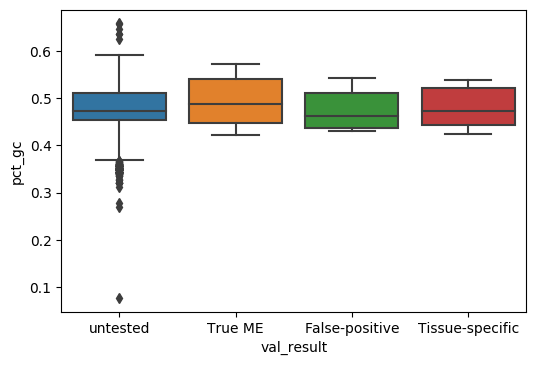

In [65]:
sns.boxplot(x="val_result", y="pct_gc", data=nuc_df)

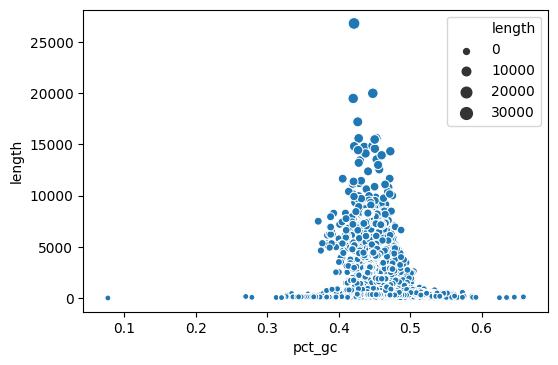

In [62]:
sns.scatterplot(x="pct_gc", y="length", data=nuc_df)